# Sample portfolio 2

This notebook runs through the library on the one of the examples in the __'sample_portfolio2'__

At the end we optimize to get the results of all the 8 different views

First we import everything

In [10]:
import pandas as pd 
import numpy as np
from entropy_pooling import views
from entropy_pooling import entropy_minimizer
from entropy_pooling import markoviz_optimizer

Then we get the data

In [11]:
# data_raw = pd.read_excel("data/data.xlsx").dropna(axis=1, how='all')
# weights = data_raw[["Weight"]]
# scenarios = data_raw.drop(columns = ["Weight"])/100

scenarios, prior = markoviz_optimizer.load_factor_scenarios("data/data.xlsx", scale_by_100 = True)

We load the vies

In [12]:
(A,b,C,d) = views.load(views_sheet_name = "data/sample_portfolio2_views.xlsx",
                       views_subsheet_name = 2);

We create the posterior distribution

In [13]:
c = 1 # The weight parameter for creating a confidence weighted posterior distribution
# p = np.array(weights)
# m,n = p.shape

posterior = entropy_minimizer.full_confidence_posterior(prior, A, b, C, d, verbose = True)
weighted_posterior = entropy_minimizer.confidence_weighted_posterior(prior, posterior, c)

Results
Optimal dual variable values:  [ 2.81186417 -0.97813745]
Jacobian matrix at optimum [-3.06267478e-06 -4.02899802e-07]


We get the deltas and create the asset space. Additionally, we import the additional constraints for the markoviz optimization.

We manually define to size of funds that can be used

In [14]:
total = 417000000

deltas, asset_names = markoviz_optimizer.load_asset_deltas("data/sample_portfolio2_deltas.xlsx")

asset_scenarios = markoviz_optimizer.asset_scenarios(scenarios, deltas, asset_names)

# loaded_constraints = pd.read_excel("data/sample_portfolio2_constrs.xlsx").dropna(axis=1, how='all')
# manual_constraints = (loaded_constraints.iloc[:,:-2],
#                       loaded_constraints.iloc[:,-2],
#                       loaded_constraints.iloc[:,-1])
constr_A, lb, ub = markoviz_optimizer.load_portfolio_constraints("data/sample_portfolio2_constrs.xlsx")
manual_constraints = (constr_A, lb, ub)

And finally we do Markowitz optimization on the posterior distribution and plot the outcome.

We minimize the volatility at return $\mu_0 = 0$ using the given constraints.

The optimization was succesful: True
Global Equities: 5716118.0
DM Equities: 5716120.0
EM Equities: 5716098.0
European Equities: 5716117.0
US Equities: 5716123.0
EUR Money Markets: 54510421.0
EUR Government Bonds: 89363453.0
EUR Covered Bonds: 54510406.0
EUR Investment Grade Corporate Bonds: 54510393.0
European High Yield Corporate Bonds: 41699707.0
EMD Hard Currency: 54510371.0
Hedge Funds: 19657383.0
Listed Private Equity: 19657290.0
Technical Provisions: 1.0
IR Hedges: 1.0


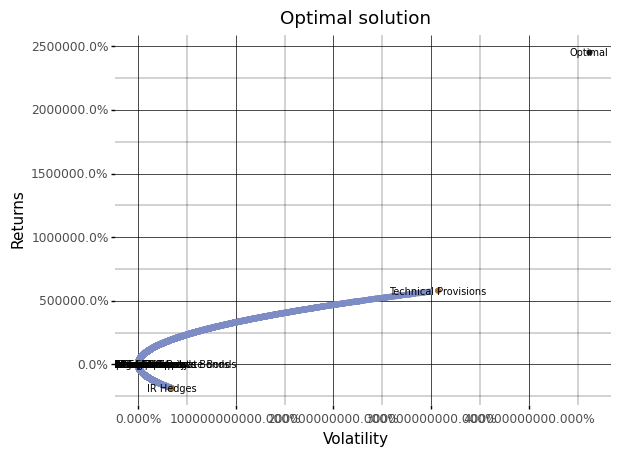

In [15]:
optimal_x = markoviz_optimizer.optimizer(asset_scenarios,
                                         weighted_posterior,
                                         mu_0 = 0,
                                         manual_constraints = manual_constraints,
                                         visualize = True,
                                         verbose = 1).x
for i, col in enumerate(asset_scenarios.columns):
  #print("{}: {}%".format(col, np.round(optimal_x[i]*100,decimals = 1)))
  print("{}: {}".format(col, np.round(optimal_x[i],decimals = 0)))

We can compare the optimization of the posterior distribution with the prior below

The optimization was succesful: False
The optimization was terminated due to: 
Positive directional derivative for linesearch
Global Equities: 0.0
DM Equities: 0.0
EM Equities: 0.0
European Equities: 0.0
US Equities: 0.0
EUR Money Markets: 0.0
EUR Government Bonds: 0.0
EUR Covered Bonds: 0.0
EUR Investment Grade Corporate Bonds: 0.0
European High Yield Corporate Bonds: 0.0
EMD Hard Currency: 0.0
Hedge Funds: 0.0
Listed Private Equity: 1.0
Technical Provisions: 0.0
IR Hedges: 0.0


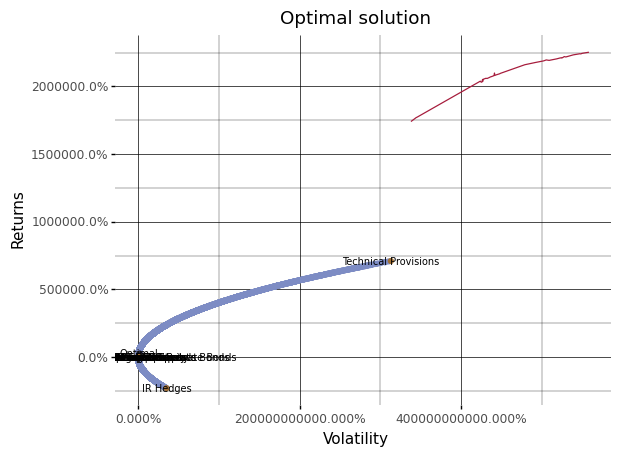

In [16]:
optimal_x = markoviz_optimizer.optimizer(asset_scenarios,
                                         prior,
                                         mu_0 = 0.01*total,
                                         manual_constraints = manual_constraints,
                                         visualize = True,
                                         verbose = 1).x

for i, col in enumerate(asset_scenarios.columns):
  #print("{}: {}%".format(col, np.round(optimal_x[i]*100,decimals = 1)))
  print("{}: {}".format(col, np.round(optimal_x[i],decimals = 0)))

In [20]:
result = pd.DataFrame(columns = range(8), index =['Result','Optimal risk', 'Expected return', *asset_names])
weights_pos = pd.DataFrame(columns = range(8))
for i in range(8):
  (A,b,C,d) = views.load(views_sheet_name = "data/sample_portfolio2_views.xlsx", views_subsheet_name = i);
  c = 1                 #scenario probability
  p = np.array(prior)
  m = p.shape

  posterior = entropy_minimizer.full_confidence_posterior(p, A,b,C,d)
  weighted_posterior = entropy_minimizer.confidence_weighted_posterior(p, posterior, c)
  weights_pos.iloc[:,i] = weighted_posterior
  optimal = markoviz_optimizer.optimizer(asset_scenarios,
                                         weighted_posterior,
                                         mu_0 = 0,
                                         manual_constraints = manual_constraints,
                                         visualize = False,
                                         verbose = 0)
  probabilities_reshaped = np.asarray(weighted_posterior).reshape(-1,)
  mu = np.average(asset_scenarios, axis=0, weights = probabilities_reshaped)
  result.iloc[0,i] = optimal.success
  result.iloc[1,i] = np.round(optimal.fun, decimals= 0)
  result.iloc[2,i] = np.round(optimal.x @ mu, decimals= 0)
  result.iloc[3:,i] = np.round(optimal.x, decimals= 0)
result
  

,0,1,2,3,4,5,6,7
Result,True,False,True,True,True,True,True,True
Optimal risk,65764.0,1815.0,67947.0,79332.0,74323.0,64244.0,71495.0,65287.0
Expected return,10351.0,-3020.0,24540.0,7710.0,22455.0,23858.0,15907.0,25414.0
Global Equities,9433187.0,0.0,5716118.0,10078801.0,11628845.0,10322114.0,10828061.0,10542200.0
DM Equities,11243957.0,0.0,5716120.0,13654253.0,12674033.0,11394063.0,13088789.0,11644790.0
EM Equities,11.0,0.0,5716098.0,1246.0,-0.0,0.0,-0.0,0.0
European Equities,12.0,0.0,5716117.0,3482.0,0.0,0.0,-0.0,-0.0
US Equities,19603132.0,1.0,5716123.0,17725970.0,17397094.0,19655030.0,17783059.0,19397121.0
EUR Money Markets,52318109.0,0.0,54510421.0,51294218.0,52125352.0,52158936.0,52125090.0,52150188.0
EUR Government Bonds,84328843.0,0.0,89363453.0,87550786.0,83400044.0,83601993.0,83400067.0,83488272.0


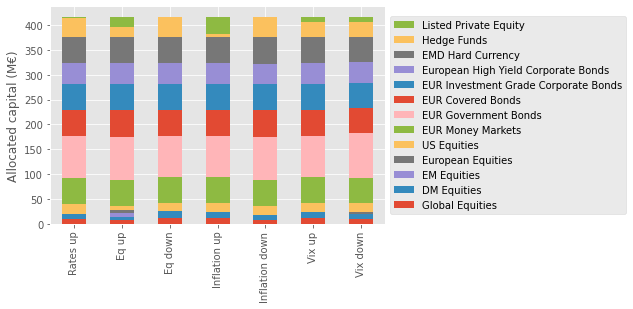

In [ ]:
import matplotlib as plt

plt.style.use('ggplot')
#labels = result.columns[result. == 'True']
result.columns = ['Rates up', 'Rates down', 'Eq up', 'Eq down', 'Inflation up', 'Inflation down', 'Vix up', 'Vix down']
filtered_res = result.iloc[3:-2, [0,2,3,4,5,6,7]]
#print(filtered_res)
#titles = ['Rates up', 'Rates down', 'Eq up', 'Eq down', 'Inflation up', 'Inflation down', 'Vix up', 'Vix down']
filtered_res = filtered_res / 1e6
ax = filtered_res.T.plot.bar(stacked=True,ylabel="Allocated capital (M€)")#,figsize=(6.4*1.5, 4.8*1.5))
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles[::-1], labels[::-1], loc='center left',bbox_to_anchor=(1.0, 0.5));
#leg.legendHandles = reversed(ax.legendHandles)
#labels = ax.legendLabels
fig = ax.get_figure()
fig.savefig('plots/stacked_barplot.pdf',bbox_inches='tight')
        

Views:   0%|          | 0/8 [00:00<?, ?it/s]

Precision:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\Christian Segercrant\AppData\Roaming\Python\Python39\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\Christian Segercrant\AppData\Roaming\Python\Python39\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plots/stacked_Rates_up.eps


Precision:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\Christian Segercrant\AppData\Roaming\Python\Python39\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\Christian Segercrant\AppData\Roaming\Python\Python39\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plots/stacked_Rates_down.eps


Precision:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\Christian Segercrant\AppData\Roaming\Python\Python39\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\Christian Segercrant\AppData\Roaming\Python\Python39\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plots/stacked_Eq_up.eps


Precision:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\Christian Segercrant\AppData\Roaming\Python\Python39\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\Christian Segercrant\AppData\Roaming\Python\Python39\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plots/stacked_Eq_down.eps


Precision:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\Christian Segercrant\AppData\Roaming\Python\Python39\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\Christian Segercrant\AppData\Roaming\Python\Python39\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plots/stacked_Inflation_up.eps


Precision:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\Christian Segercrant\AppData\Roaming\Python\Python39\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\Christian Segercrant\AppData\Roaming\Python\Python39\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plots/stacked_Inflation_down.eps


Precision:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\Christian Segercrant\AppData\Roaming\Python\Python39\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\Christian Segercrant\AppData\Roaming\Python\Python39\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plots/stacked_Vix_up.eps


Precision:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\Christian Segercrant\AppData\Roaming\Python\Python39\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\Christian Segercrant\AppData\Roaming\Python\Python39\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plots/stacked_Vix_down.eps


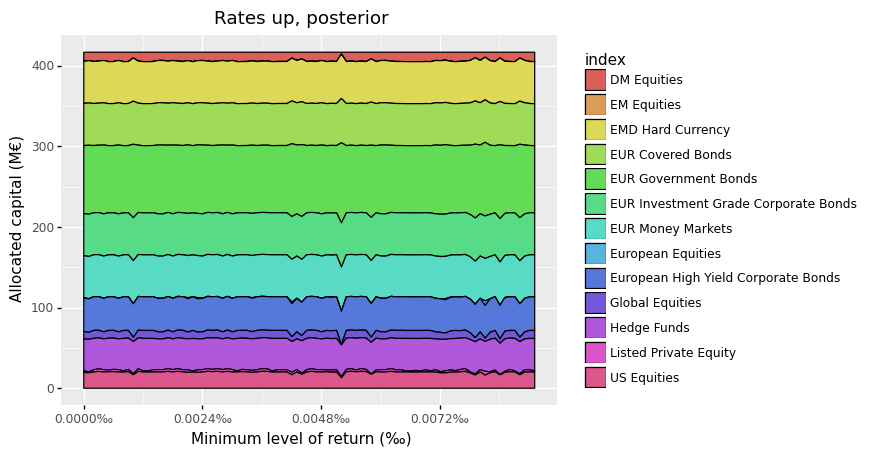

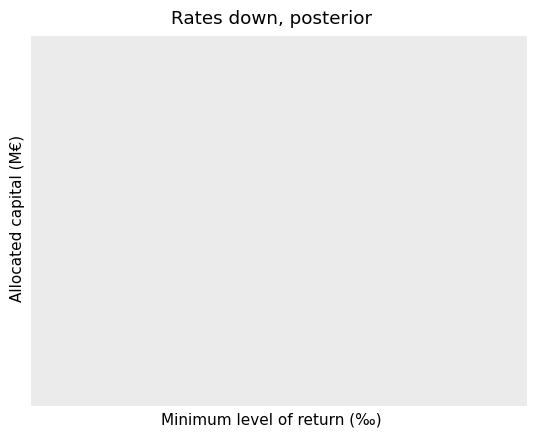

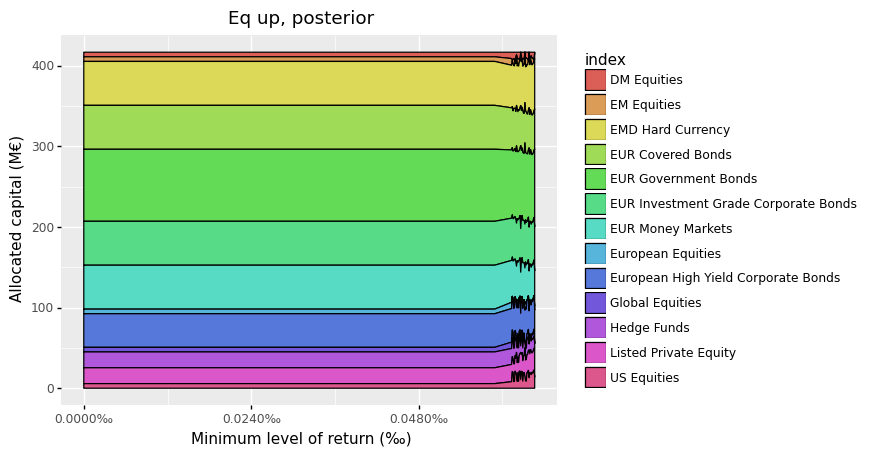

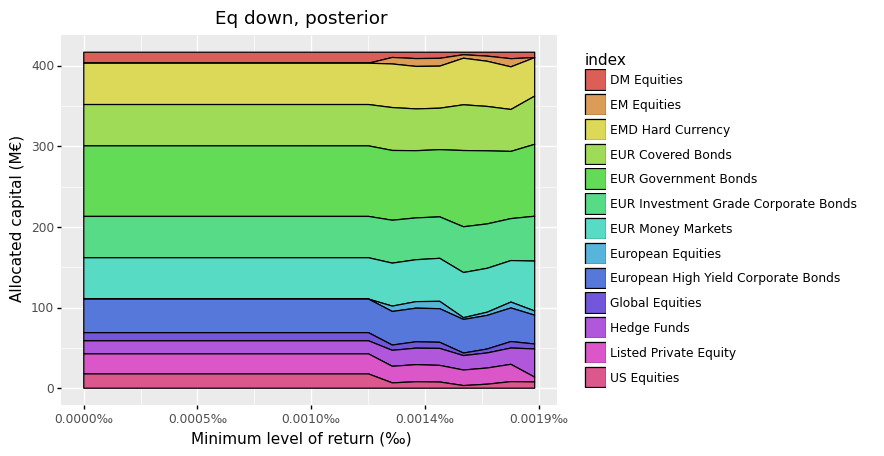

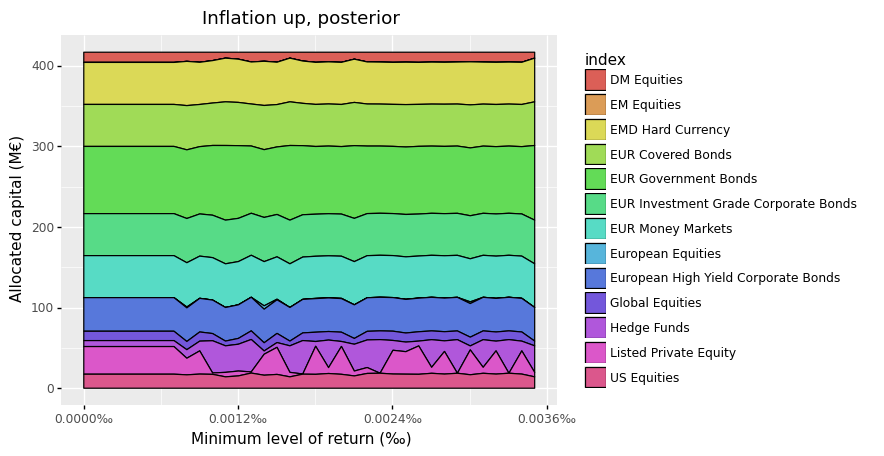

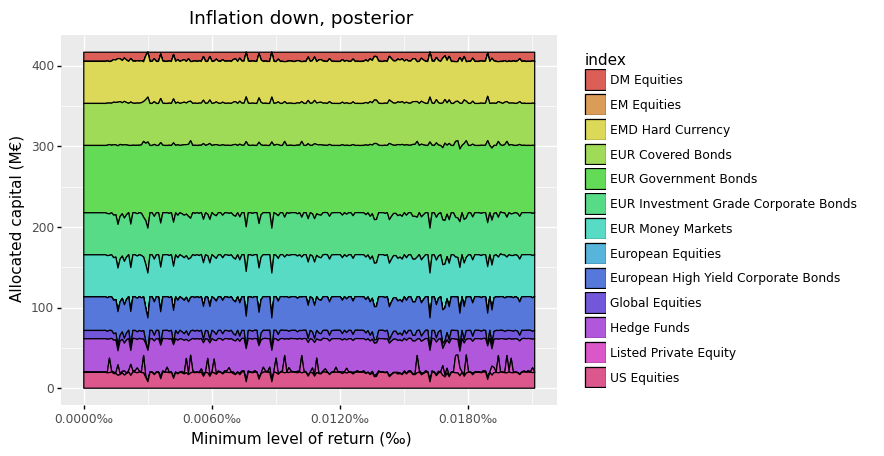

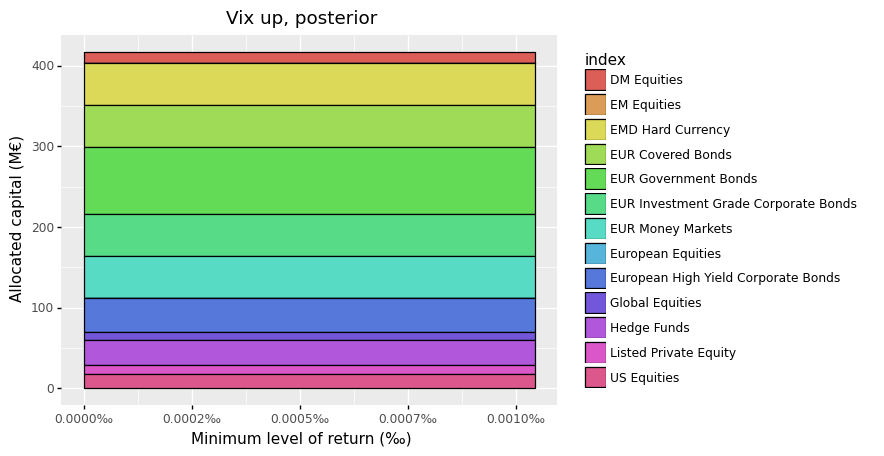

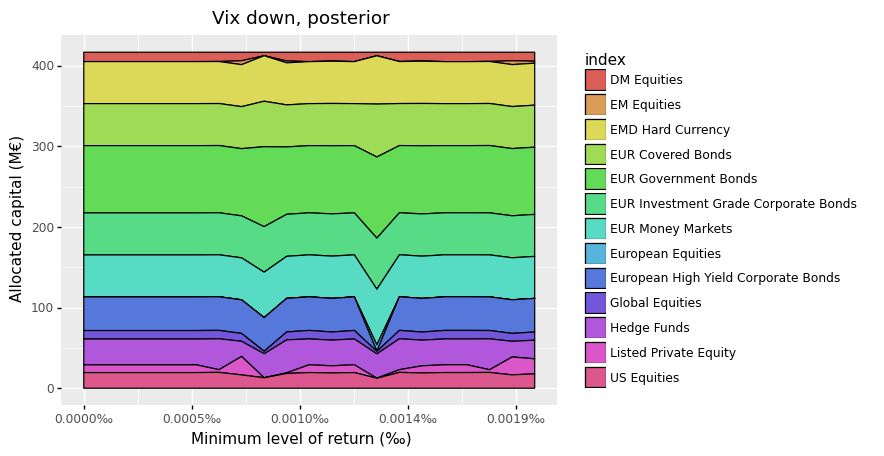

In [25]:
from plotnine import ggplot, geom_area, aes, labs, scale_x_continuous
from tqdm.notebook import tqdm
#from matplotlib import rc
#rc('text', usetex=True)
titles = ['Rates up', 'Rates down', 'Eq up', 'Eq down', 'Inflation up', 'Inflation down', 'Vix up', 'Vix down']
view_bar = tqdm(range(len(titles)), total=len(titles), desc=f"Views")
for k in view_bar:
  (A,b,C,d) = views.load(views_sheet_name = "data/sample_portfolio2_views.xlsx",
                        views_subsheet_name = k);
  precision = 1000
  precision_bar = tqdm(range(precision), total=precision, desc=f"Precision")
  result = pd.DataFrame(columns = range(precision), index =['Result','Optimal risk', 'Expected return', *asset_names])
  for i in precision_bar:
    c = 1                 #scenario probability 1 = 100% posteriori
    p = np.array(prior)
    m = p.shape
    mu_0 = np.linspace(start = 0, stop = total*0.0001, num = precision)
    posterior = entropy_minimizer.full_confidence_posterior(p, A,b,C,d)
    weighted_posterior = entropy_minimizer.confidence_weighted_posterior(p, posterior, c)
    optimal = markoviz_optimizer.optimizer(asset_scenarios,
                                          weighted_posterior,
                                          mu_0 = mu_0[i],
                                          manual_constraints = manual_constraints,
                                          visualize = False,
                                          verbose = 0)
    if optimal.success == False:
      break
    probabilities_reshaped = np.asarray(weighted_posterior).reshape(-1,)
    mu = np.average(asset_scenarios, axis=0, weights = probabilities_reshaped)
    result.iloc[0,i] = optimal.success
    if optimal.success:
      result.iloc[1,i] = np.round(optimal.fun, decimals= 0)
      result.iloc[2,i] = np.round(optimal.x @ mu, decimals= 0)
      result.iloc[3:,i] = np.round(optimal.x, decimals= 0)
    # else:
    #   result.iloc[1,i] = 0
    #   result.iloc[2,i] = 0
    #   result.iloc[3:,i] = np.zeros_like(result.iloc[3:,i])
    
  result.columns = mu_0
  result.drop(index = ["IR Hedges", "Technical Provisions"], inplace=True)
  result.dropna(axis=1, how='all', inplace=True)
  melted= result.iloc[3:,:].melt(ignore_index=False).reset_index()
  melted = melted.astype({"value": float})
  melted.value /= 1000000

  plot = (ggplot(data = melted, mapping =  aes( x='variable', fill='index', y='value')) 
          + geom_area(colour = "black")
          + labs(title=f"{titles[k]}, posterior", y="Allocated capital (M€)", x="Minimum level of return (‰)")
          + scale_x_continuous(labels=lambda l: ["%.4f‰" % (v/total * 1000) for v in l])
          )
  plot.draw();
  filename = f'stacked_{"_".join(titles[k].split(" "))}'
  plot.save(f'plots/{filename}.eps');

Precision:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\Christian Segercrant\AppData\Roaming\Python\Python39\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\Christian Segercrant\AppData\Roaming\Python\Python39\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plots/stacked_prior.eps


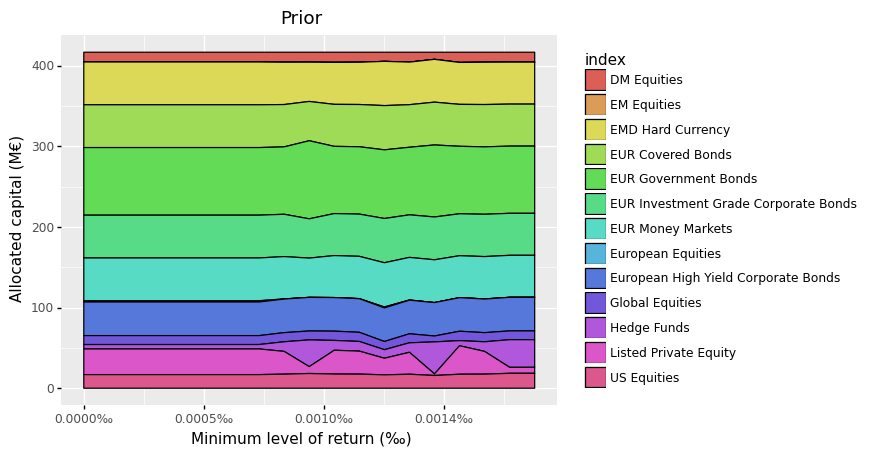

In [23]:
  precision = 1000
  precision_bar = tqdm(range(precision), total=precision, desc=f"Precision")
  result = pd.DataFrame(columns = range(precision), index =['Result','Optimal risk', 'Expected return', *asset_names])
  for i in precision_bar:
    c = 1                 #scenario probability 1 = 100% posteriori
    p = np.array(prior)
    m = p.shape
    mu_0 = np.linspace(start = 0, stop = total*0.0001, num = precision)
    optimal = markoviz_optimizer.optimizer(asset_scenarios,
                                          prior,
                                          mu_0 = mu_0[i],
                                          manual_constraints = manual_constraints,
                                          visualize = False,
                                          verbose = 0)
    if optimal.success == False:
      break
    probabilities_reshaped = np.asarray(weighted_posterior).reshape(-1,)
    mu = np.average(asset_scenarios, axis=0, weights = probabilities_reshaped)
    result.iloc[0,i] = optimal.success
    if optimal.success:
      result.iloc[1,i] = np.round(optimal.fun, decimals= 0)
      result.iloc[2,i] = np.round(optimal.x @ mu, decimals= 0)
      result.iloc[3:,i] = np.round(optimal.x, decimals= 0)
    # else:
    #   result.iloc[1,i] = 0
    #   result.iloc[2,i] = 0
    #   result.iloc[3:,i] = np.zeros_like(result.iloc[3:,i])
    
  result.columns = mu_0
  result.drop(index = ["IR Hedges", "Technical Provisions"], inplace=True)
  result.dropna(axis=1, how='all', inplace=True)
  melted= result.iloc[3:,:].melt(ignore_index=False).reset_index()
  melted = melted.astype({"value": float})
  melted.value /= 1000000

  plot = (ggplot(data = melted, mapping =  aes( x='variable', fill='index', y='value')) 
          + geom_area(colour = "black")
          + labs(title="Prior", y="Allocated capital (M€)", x="Minimum level of return (‰)")
          + scale_x_continuous(labels=lambda l: ["%.4f‰" % (v/total * 1000) for v in l])
          )
  plot.draw();
  filename = f'stacked_prior'
  plot.save(f'plots/{filename}.eps');